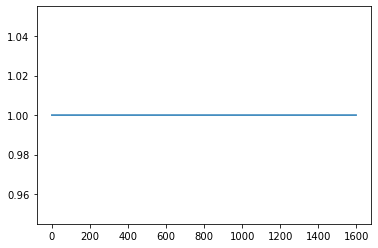

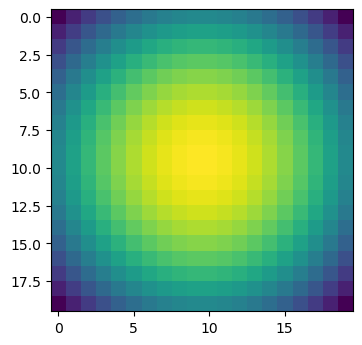

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from offline_RL import q_val_iter, get_q_func, get_policy, get_random_policy, offline_q_val_iter, gen_dataset
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics.pairwise import rbf_kernel

from fnc_compress import *

from tqdm.notebook import tqdm

import copy

####Setup the MDP 
n_action = 4
#0 north, 1 east, 2 south, 3 west
grid_dim = 20
n_state = grid_dim * grid_dim
np.random.seed(0)
# rewards = np.random.randint(0,100,size=(n_state,n_action))
#plt.plot(rewards)
np.random.seed(0)
# t_matrix = np.random.rand(n_state,n_action,n_state)
t_matrix = np.zeros((n_state,n_action,n_state))
#plt.figure()
#plt.plot(t_matrix[0][0])
sums = []
success_prob = 0.8
for i in range(n_state):
    # left edge
    # if (i % grid_dim) == 0:
    #     #north west corner
    if i == 0:
        #north
        #t_matrix[i][0][i-grid_dim] = 0
        t_matrix[i][0][i+grid_dim] = 1/2
        #t_matrix[i][0][i-1] = 0
        t_matrix[i][0][i+1] = 1/2
        #east
        #t_matrix[i][1][i-grid_dim] = 0
        t_matrix[i][1][i+grid_dim] = (1-success_prob)
        #t_matrix[i][1][i-1] = 0
        t_matrix[i][1][i+1] = success_prob
        #south
        #t_matrix[i][2][i-grid_dim] = 0
        t_matrix[i][2][i+grid_dim] = success_prob
        #t_matrix[i][2][i-1] = 0
        t_matrix[i][2][i+1] = (1-success_prob)
        #west
        #t_matrix[i][3][i-grid_dim] = 0
        t_matrix[i][3][i+grid_dim] = 1/2
        #t_matrix[i][3][i-1] = 0
        t_matrix[i][3][i+1] = 1/2
    # north east corner
    elif i == (grid_dim-1):
        #north
        #t_matrix[i][0][i-grid_dim] = 0
        t_matrix[i][0][i+grid_dim] = 1/2
        t_matrix[i][0][i-1] = 1/2
        #t_matrix[i][0][i+1] = 0
        #east
        #t_matrix[i][1][i-grid_dim] = 0
        t_matrix[i][1][i+grid_dim] = 1/2 
        t_matrix[i][1][i-1] = 1/2
        #t_matrix[i][1][i+1] = 0
        #south
        #t_matrix[i][2][i-grid_dim] = 0
        t_matrix[i][2][i+grid_dim] = success_prob
        t_matrix[i][2][i-1] = (1-success_prob)
        #t_matrix[i][2][i+1] = 0
        #west
        #t_matrix[i][3][i-grid_dim] = 0
        t_matrix[i][3][i+grid_dim] = (1-success_prob)
        t_matrix[i][3][i-1] = success_prob
        #t_matrix[i][3][i+1] = 0
    # south west corner
    elif i == grid_dim * (grid_dim-1):
        #north
        t_matrix[i][0][i-grid_dim] = success_prob
        #t_matrix[i][0][i+grid_dim] = 0
        #t_matrix[i][0][i-1] = 0
        t_matrix[i][0][i+1] = 1-success_prob
        #east
        t_matrix[i][1][i-grid_dim] = 1-success_prob
        #t_matrix[i][1][i+grid_dim] = 0
        #t_matrix[i][1][i-1] = 0
        t_matrix[i][1][i+1] = success_prob
        #south
        t_matrix[i][2][i-grid_dim] = 1/2
        #t_matrix[i][2][i+grid_dim] = 0
        #t_matrix[i][2][i-1] = 0
        t_matrix[i][2][i+1] = 1/2
        #west
        t_matrix[i][3][i-grid_dim] = 1/2
        #t_matrix[i][3][i+grid_dim] = 0
        #t_matrix[i][3][i-1] = 0
        t_matrix[i][3][i+1] = 1/2
    # south east corner
    elif i == grid_dim * grid_dim - 1:
        #north
        t_matrix[i][0][i-grid_dim] = success_prob
        #t_matrix[i][0][i+grid_dim] = 0
        t_matrix[i][0][i-1] = 1-success_prob
        #t_matrix[i][0][i+1] = 0
        #east
        t_matrix[i][1][i-grid_dim] = 1/2
        #t_matrix[i][1][i+grid_dim] = 0
        t_matrix[i][1][i-1] = 1/2
        #t_matrix[i][1][i+1] = 0
        #south
        t_matrix[i][2][i-grid_dim] = 1/2
        #t_matrix[i][2][i+grid_dim] = 0
        t_matrix[i][2][i-1] = 1/2
        #t_matrix[i][2][i+1] = 0
        #west
        t_matrix[i][3][i-grid_dim] = (1-success_prob)
        #t_matrix[i][3][i+grid_dim] = 0
        t_matrix[i][3][i-1] = success_prob
        #t_matrix[i][3][i+1] = 0
    # north border not in corners
    elif i < grid_dim:
        #north 
        #t_matrix[i][0][i-grid_dim] = 0
        t_matrix[i][0][i+grid_dim] = 1/3
        t_matrix[i][0][i-1] = 1/3
        t_matrix[i][0][i+1] = 1/3
        #east
        #t_matrix[i][1][i-grid_dim] = 0
        t_matrix[i][1][i+grid_dim] = (1-success_prob)/2
        t_matrix[i][1][i-1] = (1-success_prob)/2
        t_matrix[i][1][i+1] = success_prob
        #south
        #t_matrix[i][2][i-grid_dim] = 0
        t_matrix[i][2][i+grid_dim] = success_prob
        t_matrix[i][2][i-1] = (1-success_prob)/2
        t_matrix[i][2][i+1] = (1-success_prob)/2
        #west
        #t_matrix[i][3][i-grid_dim] = 0
        t_matrix[i][3][i+grid_dim] = (1-success_prob)/2
        t_matrix[i][3][i-1] = success_prob
        t_matrix[i][3][i+1] = (1-success_prob)/2
    # west border not in corners
    elif i%grid_dim==0:
        #north 
        t_matrix[i][0][i-grid_dim] = success_prob
        t_matrix[i][0][i+grid_dim] = (1-success_prob)/2
        #t_matrix[i][0][i-1] = 0
        t_matrix[i][0][i+1] = (1-success_prob)/2
        #east
        t_matrix[i][1][i-grid_dim] = (1-success_prob)/2
        t_matrix[i][1][i+grid_dim] = (1-success_prob)/2
        #t_matrix[i][1][i-1] = 0
        t_matrix[i][1][i+1] = success_prob
        #south
        t_matrix[i][2][i-grid_dim] = (1-success_prob)/2
        t_matrix[i][2][i+grid_dim] = success_prob
        #t_matrix[i][2][i-1] = 0
        t_matrix[i][2][i+1] = (1-success_prob)/2
        #west
        t_matrix[i][3][i-grid_dim] = 1/3
        t_matrix[i][3][i+grid_dim] = 1/3
        #t_matrix[i][3][i-1] = 0
        t_matrix[i][3][i+1] = 1/3
    # east border not in corners
    elif (i+1)%grid_dim==0:
        #north 
        t_matrix[i][0][i-grid_dim] = success_prob
        t_matrix[i][0][i+grid_dim] = (1-success_prob)/2
        t_matrix[i][0][i-1] = (1-success_prob)/2
        #t_matrix[i][0][i+1] = 0
        #east
        t_matrix[i][1][i-grid_dim] = 1/3
        t_matrix[i][1][i+grid_dim] = 1/3
        t_matrix[i][1][i-1] = 1/3
        #t_matrix[i][1][i+1] = 0
        #south
        t_matrix[i][2][i-grid_dim] = (1-success_prob)/2
        t_matrix[i][2][i+grid_dim] = success_prob
        t_matrix[i][2][i-1] = (1-success_prob)/2
        #t_matrix[i][2][i+1] = 0
        #west
        t_matrix[i][3][i-grid_dim] = (1-success_prob)/2
        t_matrix[i][3][i+grid_dim] = (1-success_prob)/2
        t_matrix[i][3][i-1] = success_prob
        #t_matrix[i][3][i+1] = 0
    # south border not in corners
    elif i > grid_dim * (grid_dim-1):
        #north 
        t_matrix[i][0][i-grid_dim] = success_prob
        #t_matrix[i][0][i+grid_dim] = 0
        t_matrix[i][0][i-1] = (1-success_prob)/2
        t_matrix[i][0][i+1] = (1-success_prob)/2
        #east
        t_matrix[i][1][i-grid_dim] = (1-success_prob)/2
        #t_matrix[i][1][i+grid_dim] = 0
        t_matrix[i][1][i-1] = (1-success_prob)/2
        t_matrix[i][1][i+1] = success_prob
        #south
        t_matrix[i][2][i-grid_dim] = 1/3
        #t_matrix[i][2][i+grid_dim] = 0
        t_matrix[i][2][i-1] = 1/3
        t_matrix[i][2][i+1] = 1/3
        #west
        t_matrix[i][3][i-grid_dim] = (1-success_prob)/2
        #t_matrix[i][3][i+grid_dim] = 0
        t_matrix[i][3][i-1] = success_prob
        t_matrix[i][3][i+1] = (1-success_prob)/2
    # inner state case
    else:
        #north
        t_matrix[i][0][i-grid_dim] = success_prob
        t_matrix[i][0][i+grid_dim] = (1-success_prob)/3
        t_matrix[i][0][i-1] = (1-success_prob)/3
        t_matrix[i][0][i+1] = (1-success_prob)/3
        #east
        t_matrix[i][1][i-grid_dim] = (1-success_prob)/3
        t_matrix[i][1][i+grid_dim] = (1-success_prob)/3
        t_matrix[i][1][i-1] = (1-success_prob)/3
        t_matrix[i][1][i+1] = success_prob
        #south
        t_matrix[i][2][i-grid_dim] = (1-success_prob)/3
        t_matrix[i][2][i+grid_dim] = success_prob
        t_matrix[i][2][i-1] = (1-success_prob)/3
        t_matrix[i][2][i+1] = (1-success_prob)/3
        #west
        t_matrix[i][3][i-grid_dim] = (1-success_prob)/3
        t_matrix[i][3][i+grid_dim] = (1-success_prob)/3
        t_matrix[i][3][i-1] = success_prob
        t_matrix[i][3][i+1] = (1-success_prob)/3

for i in range(n_state):
    for j in range(n_action):
        # t_matrix[i][j] = t_matrix[i][j]/np.sum(t_matrix[i][j])
        sums.append(np.sum(t_matrix[i][j]))
#check to make sure valid transition probabilities have been create
plt.plot(sums)

gamma = 0.99

# dataset_len = 5000
# delta_tol = 1
rew_sigma = 2*grid_dim**2

x = np.arange(grid_dim)
y = np.arange(grid_dim)

xx, yy = np.meshgrid(x,y)
xy = np.vstack([yy.reshape(-1),xx.reshape(-1)]).T

rew_dists = cdist(xy,np.reshape([(grid_dim-1)/2,(grid_dim-1)/2],(1,-1)),metric='sqeuclidean')
rew_vect = np.exp(-rew_dists/rew_sigma)
rew_vect2d = np.reshape(rew_vect,(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(rew_vect2d)
rewards = np.tile(rew_vect,(1,n_action))

dataset_len = 1000
lamd = 1
# delta_tol = 0.01
delta_tol =  0.9

num_agents = 4

# Adj = np.array([[1/3, 1/3, 0, 1/3], 
#                 [1/3, 1/3, 1/3, 0],
#                 [0, 1/3, 1/3, 1/3],
#                 [1/3, 0, 1/3, 1/3]])
share_rate = 1/2
# Adj = np.array([[1-2*share_rate, share_rate, 0, share_rate], 
#                  [share_rate, 1-2*share_rate, share_rate, 0],
#                  [0, share_rate, 1-2*share_rate, share_rate],
#                  [share_rate, 0, share_rate, 1-2*share_rate]])
Adj = np.array([[1-share_rate, share_rate, 0, 0], 
                 [0, 1-share_rate, share_rate, 0],
                 [0, 0, 1-share_rate, share_rate],
                 [share_rate, 0, 0, 1-share_rate]])
nodelist = list(range(0,num_agents))

def cycle(my_list, start_at):
    count = 0
    newlst = []
    while count<4 :
        newlst.append(my_list[start_at])
        start_at = (start_at + 1) % len(my_list)
        count += 1
    return newlst

In [21]:
num_agents = 4
region_dim = int(grid_dim/2)

regions_all = np.zeros((num_agents,region_dim**2))

for a in range(num_agents):
    x,y = np.divmod(a,2)
    print('x= '+str(x))
    print('y= '+str(y))
    region_states = []
    base = int(x*(grid_dim/2) + y*grid_dim*(grid_dim/2))
    print(base)
    for i in range(region_dim):
        region_states.extend(np.arange(base + i*grid_dim,base + i*grid_dim+int(grid_dim/2),dtype=int))
    region_states = np.array(region_states)
    regions_all[a] = region_states

# for i in range(region_dim):
#     region_states.extend(np.arange(i*grid_dim,i*grid_dim+int(grid_dim/2)))
# region_states = np.array(region_states)

region_xy = np.zeros((num_agents,len(region_states),2))

for a in range(num_agents):
    for i in range(len(region_states)):
        region_xy[a][i] = xy[int(regions_all[a][i])]

x= 0
y= 0
0
x= 0
y= 1
200
x= 1
y= 0
10
x= 1
y= 1
210


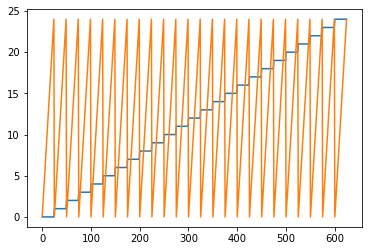

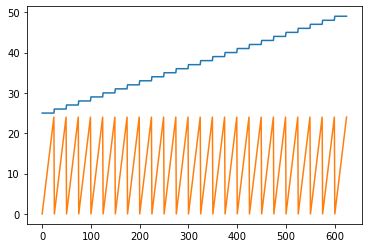

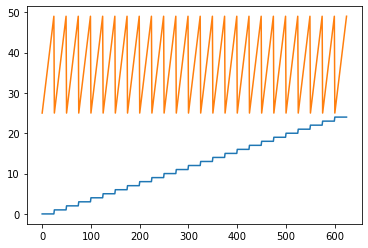

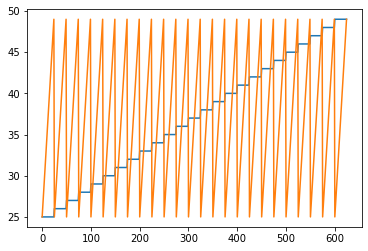

In [3]:
for a in range(num_agents):
    plt.figure()
    plt.plot(region_xy[a,:,0])
    plt.plot(region_xy[a,:,1])

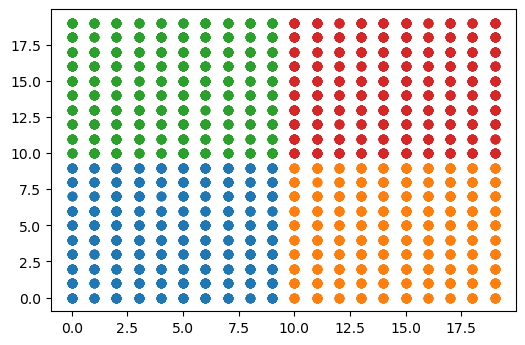

In [23]:
# dataset = np.zeros((dataset_len,3,num_agents))
sa = np.zeros((dataset_len,2,num_agents),dtype=int)
ns= np.zeros((dataset_len,1,num_agents),dtype=int)

subX = np.zeros((dataset_len,3,num_agents),dtype=int)
subY = np.zeros((dataset_len,2,num_agents),dtype=int)

in_states = np.zeros((num_agents,dataset_len,2))
out_states = np.zeros((num_agents,dataset_len,2))

for a in range(num_agents):
    for k in range(dataset_len):
        # state = np.random.choice(n_state,size=1)[0]
        # state = int(np.random.choice(np.arange(a*state_skip,(a+1)*state_skip),size=1)[0])
        state = int(np.random.choice(regions_all[a],size=1)[0])
        action = int(np.random.choice(n_action,size=1)[0])
        # dataset.append(np.array([state,action,int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))]))
        # dataset[k,:,a] = np.array([state,action,int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))])
        sa[k,:,a] = np.array([state,action],dtype=int)
        ns[k,:,a] = np.array([int(np.random.choice(n_state,size=1,p=t_matrix[state][action]))],dtype=int)
    in_states[a] = xy[sa[:,:,a].T[0]]
# actions = dataset.T[1]/n_action
    out_states[a] = xy[ns[:,:,a].T[0]]
    subX[:,:,a] = np.hstack([in_states[a],np.reshape(sa[:,:,a].T[1],(-1,1))])
    subY[:,:,a] = out_states[a]

plt.figure(dpi=100)
for a in range(num_agents):
    plt.scatter(in_states[a].T[0],in_states[a].T[1])

In [24]:
# sigma_st = 5.391556705395693
sigmas = np.zeros(num_agents)
for a in range(num_agents):
    dxx = pdist(subX[:,:,a], 'euclidean')
    dx = np.median(dxx)
    print('Mean of distance',dx)
    print()
    sigma_st = np.sqrt(dx)
    # M_data = X.shape[0]
    # N_kernel = 1
    sigmas[a] = sigma_st/8

N_kernel = 1
# sigmalist = [sigma_st/4]
sigmalist = [np.mean(sigmas)]
sigmalist = [1]
#sigmalist = [5./m]
etalist = [1]

nodes = np.arange(0,4)
subDx = {}
subDy = {}
weightDxx = {}
weightDyx = {}
dict_sizes = np.zeros(num_agents)

rcond_value = 1e-5

for j in range(0,num_agents):
    print('Compressing dictionary in node ',j)
    subDx[j],subDy[j],dict_inds = compressD(subX[:,:,j],subY[:,:,j],delta_tol,sigmalist,etalist)
    print('Shape of dictionary: ',subDx[j].shape)
    dict_sizes[j] = subDx[j].shape[0]
    weightDxx[j],weightDyx[j]=weightAverage(subY[:,:,j],subX[:,:,j],subDy[j],subDx[j],sigmalist,etalist,rcond_value)

Mean of distance 5.385164807134504

Mean of distance 5.196152422706632

Mean of distance 5.385164807134504

Mean of distance 5.196152422706632

Compressing dictionary in node  0
Shape of dictionary:  (533, 3)
Compressing dictionary in node  1
Shape of dictionary:  (535, 3)
Compressing dictionary in node  2
Shape of dictionary:  (536, 3)
Compressing dictionary in node  3
Shape of dictionary:  (519, 3)


In [11]:
sigmalist

[0.885744883773817]

In [29]:
iterateDx = {}
iterateDy = {}
iterateWxx = {}
iterateWyx = {}
# print('--------------')
# print('Iteration 1')
# for j in range(0,4):
iterations = 3
tempDx = copy.deepcopy(subDx)
tempDy = copy.deepcopy(subDy)

tempweightDxx = copy.deepcopy(weightDxx)
tempweightDyx = copy.deepcopy(weightDyx)

V_agents = np.zeros((iterations,num_agents,n_state,1))
CME_policies = np.zeros((iterations,num_agents,n_state))

for iter in range(iterations):
    print('Iteration '+str(iter))

    for j in range(num_agents):
        # print('--------------')
        # print('Working on node ',j)
        #create a cycle list starting from j
        Locallst = cycle(nodelist,start_at=j)
        # print('list starting at node',Locallst)
        # concatDx = subDx[j]
        # concatDy = subDy[j]
        # concatWxx = Adj[j][j] * weightDxx[j]
        # concatWyx = Adj[j][j] * weightDyx[j]
        concatDx = tempDx[j]
        concatDy = tempDy[j]
        concatWxx = Adj[j][j] * tempweightDxx[j]
        concatWyx = Adj[j][j] * tempweightDyx[j]
        for i in Locallst[1:]:
            if Adj[j][i] != 0:
                # concatDx = np.concatenate((concatDx,subDx[i]))
                # concatDy = np.concatenate((concatDy,subDy[i])) 
                # concatWxx = np.concatenate((concatWxx,Adj[j][i] * weightDxx[i]))
                # concatWyx = np.concatenate((concatWyx,Adj[j][i] * weightDyx[i]))
                concatDx = np.concatenate((concatDx,tempDx[i]))
                concatDy = np.concatenate((concatDy,tempDy[i])) 
                concatWxx = np.concatenate((concatWxx,Adj[j][i] * tempweightDxx[i]))
                concatWyx = np.concatenate((concatWyx,Adj[j][i] * tempweightDyx[i]))
    #            print('Dictionary before proj',concatDx.shape)
        iterateDx[j],iterateDy[j],dict_inds = compressD(concatDx,concatDy,delta_tol,sigmalist,etalist)
        D_data = iterateDx[j].shape[0]
        print('Shape of projected sparse Dictionary :',D_data)        
        # print()      
        #Find sparse weights alpha's
        locGram_ayx,locGram_axx = Grams(iterateDx[j], iterateDy[j], N_kernel,sigmalist,etalist)
        tempGram_ayx,tempGram_axx = tempGrams(concatDx,concatDy,iterateDx[j],iterateDy[j],sigmalist,etalist)
        # print(tempGram_ayx.shape)
        iterateWyx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_ayx,rtol=rcond_value),tempGram_ayx), concatWyx)
        iterateWxx[j] = np.matmul(np.matmul(scipy.linalg.pinv(locGram_axx,rtol=rcond_value),tempGram_axx), concatWxx)
    #    print('Shape of projected sparse Weight vector :', iterateWxx[j].shape)
        del concatDx,concatDy,concatWxx,concatWyx
    
    # plt.figure(dpi=200)
    # # inds_x = {}
    # for a in range(num_agents):
    #     # inds_x[a] = np.argsort(iterateDx[a].T[0])
    #     # plt.plot(np.sort(iterateDx[a].T[0]),linewidth = num_agents-a)
    #     plt.plot(iterateDx[a].T[0],linewidth = num_agents-a)
    #     # plt.plot(np.sort(iterateDx[1].T[0]))
    #     # plt.plot(np.sort(iterateDx[2].T[0]))
    #     # plt.plot(np.sort(iterateDx[3].T[0]))
    # # plt.title('X Dictionaries Iteration '+str(iter))

    # plt.figure(dpi=200)
    # for a in range(num_agents):
    #     plt.plot(iterateWxx[a],linewidth = num_agents-a)
    
    # plt.figure(dpi=200)
    # # inds_x = {}
    # for a in range(num_agents):
    #     # plt.plot(np.sort(iterateDy[a].T[0]),linewidth = num_agents-a)
    #     plt.plot(iterateDy[a].T[0],linewidth = num_agents-a)

    # plt.figure(dpi=200)
    # for a in range(num_agents):
    #     plt.plot(iterateWyx[a],linewidth = num_agents-a)
    # # plt.plot(np.sort(iterateWxx[1]))
    # # plt.plot(np.sort(iterateWxx[2]))
    # # plt.plot(np.sort(iterateWxx[3]))

    # print('Alpha calculation '+str(iter))

    alphas_agents = {}

    for j in range(num_agents):
        # print(j)
        # weightDxx,weightDyx=weightAverage(Y,X,Dy,Dx,sigmalist,etalist,rcond_value)

        nx = len(iterateDx[j])
        KXX = rbf_kernel(iterateDx[j],gamma=1.0/(2.0*sigmalist[0]**2))

        W_new = np.diag(iterateWyx[j])@np.linalg.inv(KXX@np.diag(iterateWxx[j])+np.eye(nx))

        alphas_new = np.zeros((n_state,n_action,nx))
        for state in range(n_state):
            for action in range(n_action):
                # dists = cdist(data_in,np.tile([state,action],[1,1]),metric='sqeuclidean')
                # dists = cdist(Dx,np.tile(np.append(xy[state],action),[1,1]),metric='sqeuclidean')
                dists = cdist(iterateDx[j],np.tile(np.append(xy[state],action),[1,1]),metric='sqeuclidean')
                #alphas[state][action] = np.squeeze(W@np.exp(-dists/sigma_kernel**2))
                alphas_new[state][action] = np.squeeze(W_new@np.exp(-dists/(2*sigmalist[0]**2)))
                alphas_new[state][action] = alphas_new[state][action]/np.sum(np.abs(alphas_new[state][action]) + 0.0000000001)
        alphas_agents[j] = alphas_new

    if iter <= iterations-1:

        print('Value Iteration '+str(iter))

        for j in range(num_agents):   
            V = np.zeros((n_state,1))
            # V_prod = np.zeros_like(labels)[:,np.newaxis]
            V_prod = np.zeros((iterateDy[j].shape[0],1))

            theta = 0.001
            max_val_iter = 10000
            err = np.infty

            gamma = 0.99

            val_iter = 0

            deltas = np.zeros(max_val_iter)

            CME_policy = np.zeros(n_state)

            out_state_inds = np.zeros(iterateDy[j].shape[0],dtype=int)
            for i in range(iterateDy[j].shape[0]):
                out_state_inds[i] = int(iterateDy[j][i][0] + iterateDy[j][i][1]*grid_dim)

            while val_iter<max_val_iter and err>theta:
                if not val_iter%100:
                    print('Agent '+str(j)+' iteration '+str(val_iter))
                V_temp = np.zeros_like(V)
                # print('V_temp')
                # print(V_temp)
                # print('V')
                # print(V)
                # V_prod = V[labels]
                # V_prod = V[np.squeeze(iterateDy[j]).astype(int)]
                V_prod = V[out_state_inds]
                for state in range(n_state):
                    max_buffer = np.zeros(n_action)
                    for action in range(n_action):
                        max_buffer[action] = rewards[state][action] + gamma*(alphas_agents[j][state][action]@V_prod)
                    V_temp[state] = np.max(max_buffer)
                    CME_policy[state] = np.argmax(max_buffer)
                # print('V_temp')
                # print(V_temp)
                err = np.max(np.abs(V-V_temp))
                deltas[iter] = err
                V = V_temp    
                val_iter = val_iter+1
            print('Agent '+str(j)+' iterations: '+str(val_iter))
            V_agents[iter][j] = V
            CME_policies[iter][j] = CME_policy    
        
    tempDx = copy.deepcopy(iterateDx)
    tempDy = copy.deepcopy(iterateDy)

    tempweightDxx = copy.deepcopy(iterateWxx)
    tempweightDyx = copy.deepcopy(iterateWyx)

Iteration 0
Shape of projected sparse Dictionary : 1068
Shape of projected sparse Dictionary : 1071
Shape of projected sparse Dictionary : 1055
Shape of projected sparse Dictionary : 1052
Value Iteration 0
Agent 0 iteration 0
Agent 0 iteration 100
Agent 0 iteration 200
Agent 0 iteration 300
Agent 0 iteration 400
Agent 0 iteration 500
Agent 0 iteration 600
Agent 0 iterations: 674
Agent 1 iteration 0
Agent 1 iteration 100
Agent 1 iteration 200
Agent 1 iteration 300
Agent 1 iteration 400
Agent 1 iteration 500
Agent 1 iteration 600
Agent 1 iterations: 679
Agent 2 iteration 0
Agent 2 iteration 100
Agent 2 iteration 200
Agent 2 iteration 300
Agent 2 iteration 400
Agent 2 iteration 500
Agent 2 iteration 600
Agent 2 iterations: 673
Agent 3 iteration 0
Agent 3 iteration 100
Agent 3 iteration 200
Agent 3 iteration 300
Agent 3 iteration 400
Agent 3 iteration 500
Agent 3 iteration 600
Agent 3 iterations: 678
Iteration 1
Shape of projected sparse Dictionary : 1604
Shape of projected sparse Dictiona

In [38]:
g = 10.0
m = 1.0
l = 2.0
dt = 0.05

th = 0.5

3 * g / (2 * l) * np.sin(th)

3.5956915395315225

In [39]:
(3 * g / (2 * l)) * np.sin(th)

3.5956915395315225

In [41]:
u = 2

3.0 / (m * l**2) * u

1.5

In [42]:
(3.0 / (m * l**2)) * u

1.5

/var/folders/l6/0f1yfzrj3nv3_wc8rfl3tq_h0000gn/T/ipykernel_13396/1929201903.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


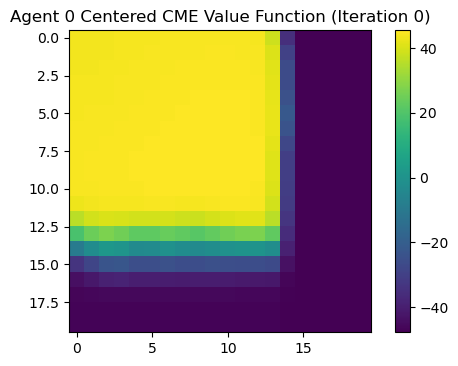

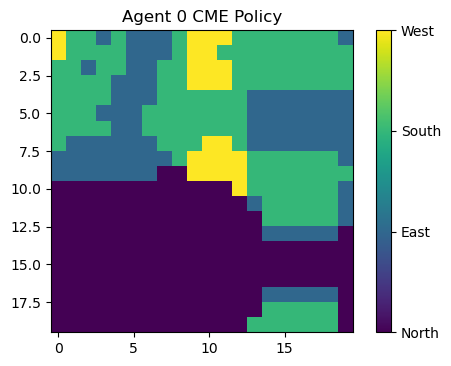

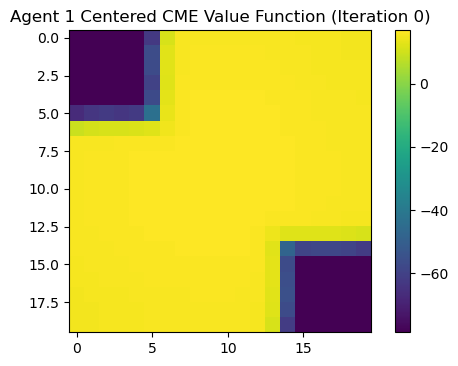

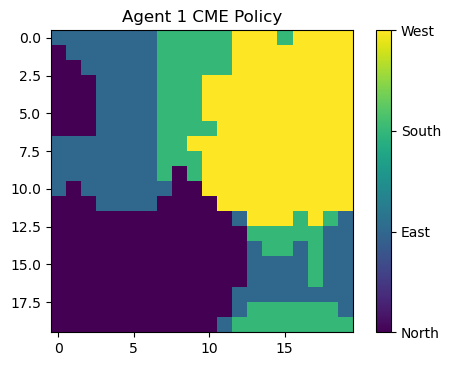

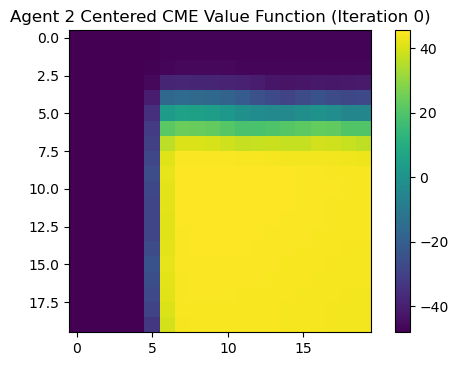

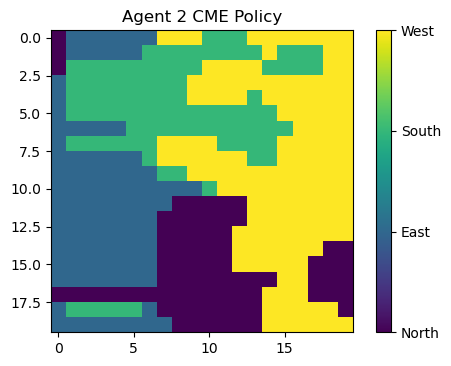

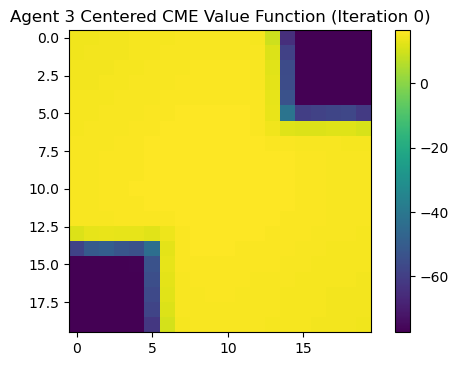

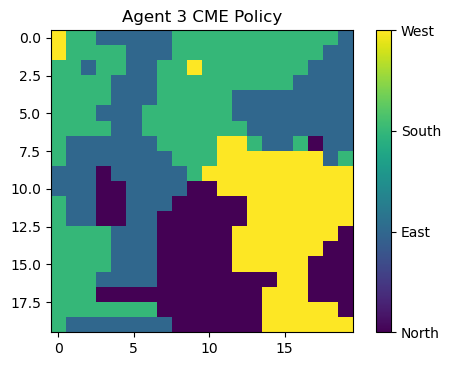

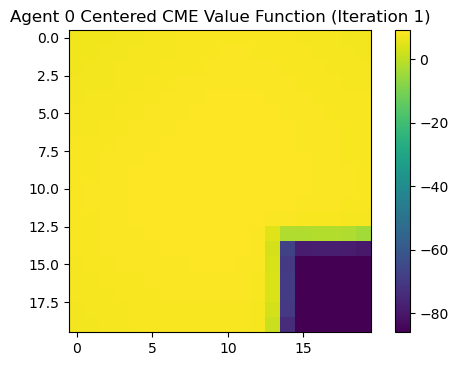

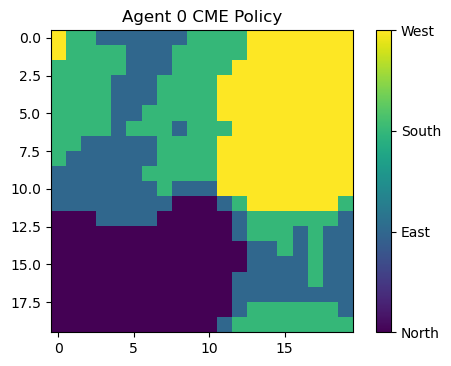

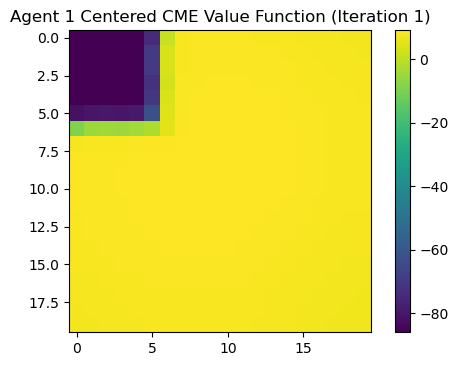

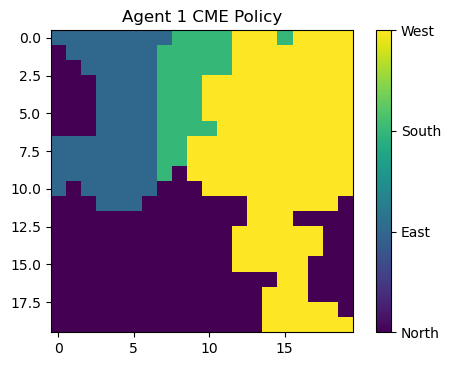

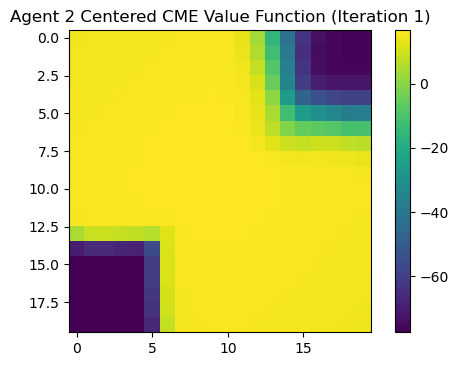

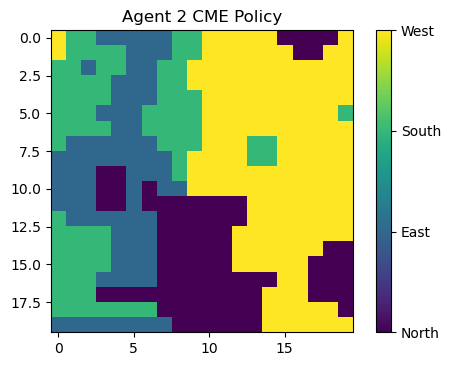

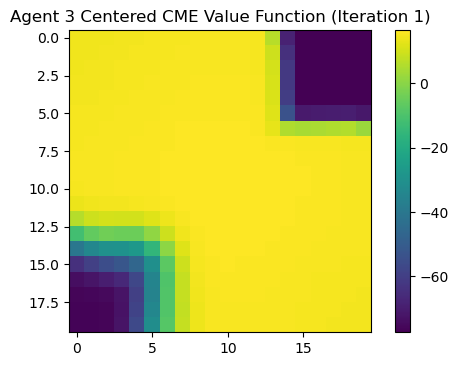

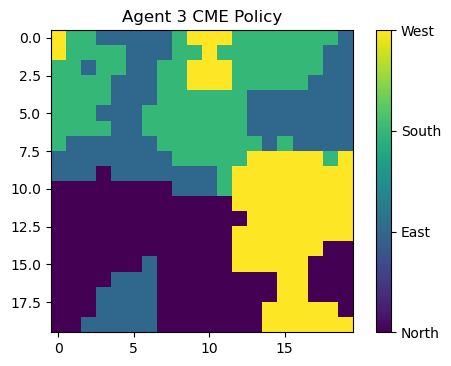

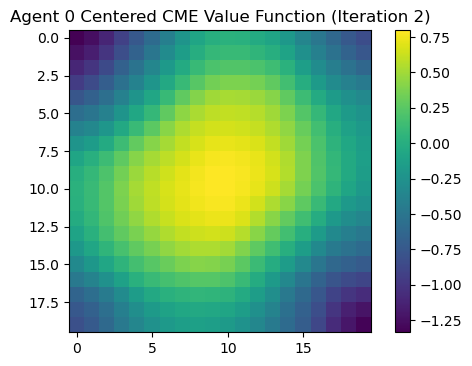

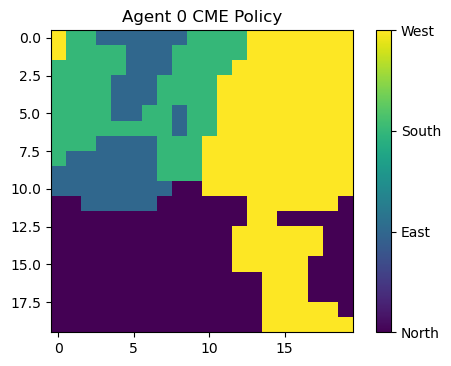

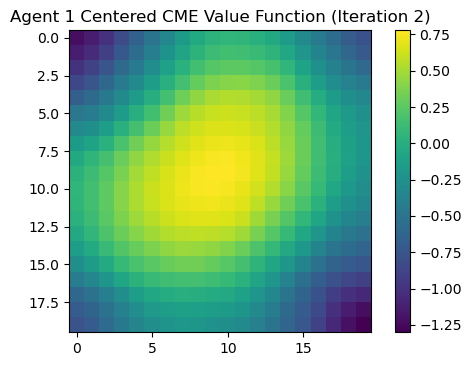

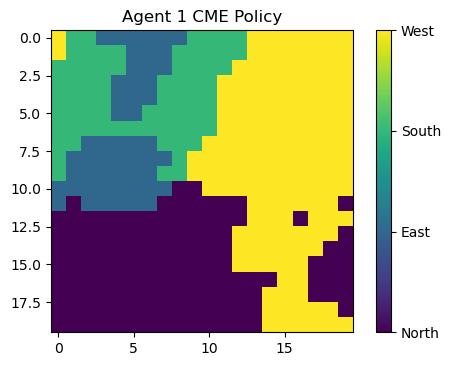

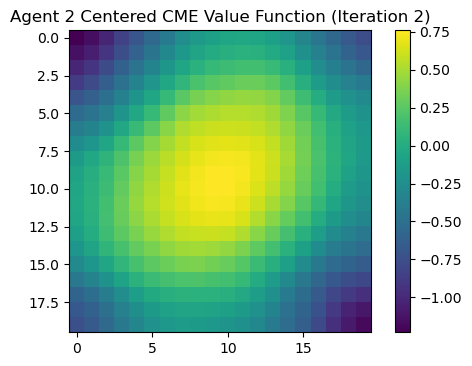

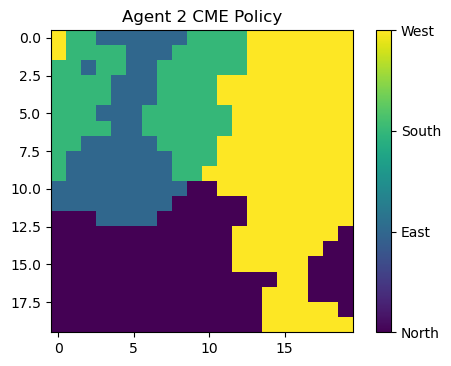

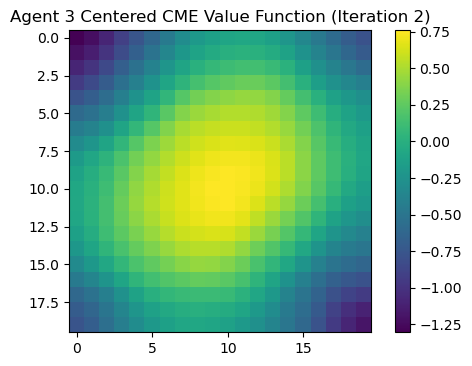

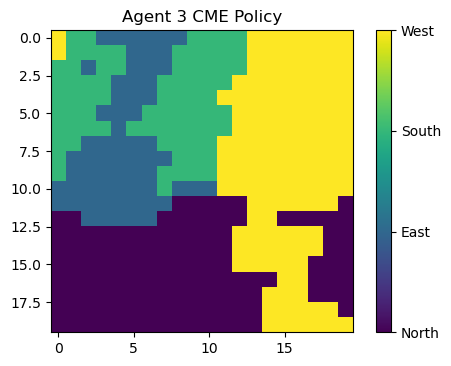

In [33]:
for iter in range(iterations):
    for j in range(num_agents):

        V_CME2d = np.reshape(V_agents[iter][j]-np.mean(V_agents[iter][j]),(grid_dim,grid_dim))
        plt.figure(dpi=100)
        plt.imshow(V_CME2d)
        plt.colorbar()
        plt.title('Agent '+str(j)+' Centered CME Value Function (Iteration '+str(iter)+')')
        CME_pol2d = np.reshape(CME_policies[iter][j],(grid_dim,grid_dim))
        plt.figure(dpi=100)
        plt.imshow(CME_pol2d)
        plt.title('Agent '+str(j)+' CME Policy')
        cbar = plt.colorbar(ticks=[0,1,2,3]);
        cbar.ax.set_yticklabels(['North', 'East', 'South', 'West']);

In [27]:
V_VI = np.zeros(n_state)

theta = 0.001
max_iter = 10000
err = np.infty

gamma = 0.99

iter = 0

deltas = []

VI_policy = np.zeros(n_state)
while iter<max_iter and err>theta:
    print(iter)
    V_temp = np.zeros_like(V_VI)
    # print('V_temp')
    # print(V_temp)
    # print('V')
    # print(V)
    for state in range(n_state):
        # V_prod[labels] = V[labels]
        max_buffer = np.zeros(n_action)
        for action in range(n_action):
            max_buffer[action] = rewards[state][action] + gamma*(np.dot(V_VI,t_matrix[state][action]))
        V_temp[state] = np.max(max_buffer)
        VI_policy[state] = np.argmax(max_buffer)
    # print('V_temp')
    # print(V_temp)
    err = np.max(np.abs(V_VI-V_temp))
    deltas.append(err)
    V_VI = V_temp    
    iter = iter+1

deltas = np.array(deltas)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

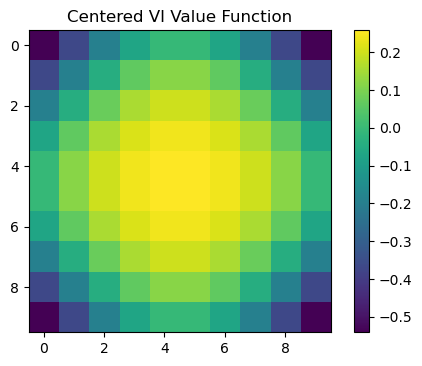

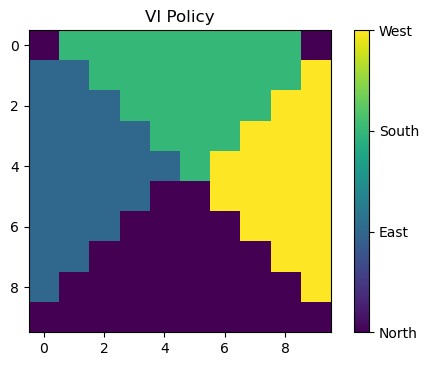

In [8]:
V_VI2d = np.reshape(V_VI-np.mean(V_VI),(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(V_VI2d)
plt.colorbar()
plt.title('Centered VI Value Function')
CME_pol2d = np.reshape(CME_policy,(grid_dim,grid_dim))
VI_pol2d = np.reshape(VI_policy,(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(VI_pol2d)
plt.title('VI Policy')
cbar = plt.colorbar(ticks=[0,1,2,3]);
cbar.ax.set_yticklabels(['North', 'East', 'South', 'West']);

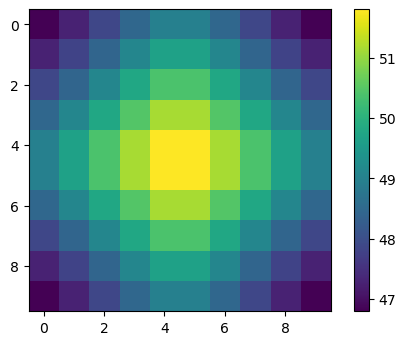

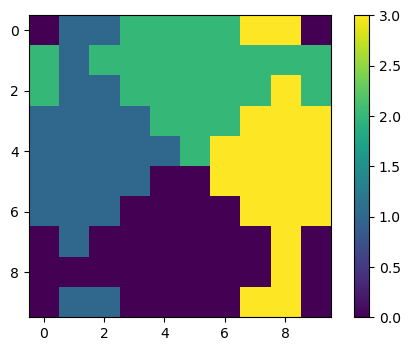

In [32]:
V_VI2d = np.reshape(V_VI,(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(V_VI2d)
plt.colorbar()
VI_pol2d = np.reshape(VI_policy,(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(VI_pol2d)
plt.colorbar()
#0 north, 1 east, 2 south, 3 west

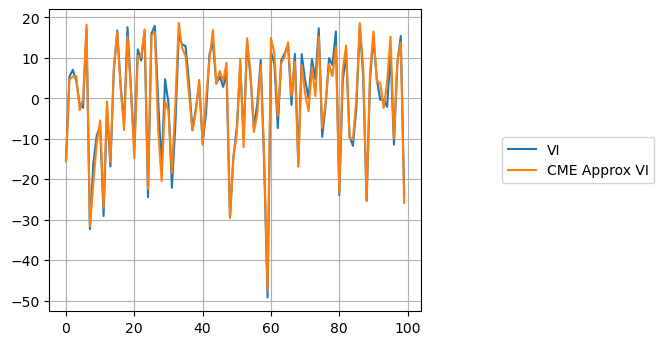

In [35]:
t = np.arange(n_state)

fig, ax1 = plt.subplots(dpi=100)

ax1.plot(V_VI-np.mean(V_VI),label='VI')
ax1.plot(V-np.mean(V),label='CME Approx VI')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left',bbox_to_anchor=(1.2, 0.5))

plt.grid()

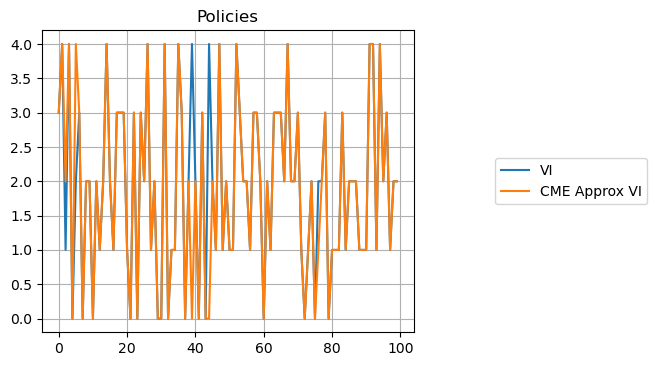

In [36]:
t = np.arange(n_state)

fig, ax1 = plt.subplots(dpi=100)

ax1.plot(VI_policy,label='VI')
ax1.plot(CME_policy,label='CME Approx VI')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left',bbox_to_anchor=(1.2, 0.5))
ax1.set_title('Policies')

plt.grid()